In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from typing import Union
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import os 

while "notebooks" in os.getcwd():
    os.chdir("..")

from src.preprocessing.lstm.make_dataset import StockReturnsDataset, \
    StockPricesDataset, get_prices_features, normalize_features,\
    generate_sentiment_features

from src.preprocessing.finbert.get_news import get_news, \
    filter_news_with_name, save_company_news_df,\
    read_company_news_df

from src.backtester import Backtester

# LSTM Analysis with Tech stock prices

## Prices

In [3]:
prices_df = yf.download(
    tickers= "AAPL",
    start="2020-01-10",
    end="2022-12-30",
)

[*********************100%***********************]  1 of 1 completed


In [4]:
universe = [
    "AMZN", 
    "AAPL", 
    "MSFT", 
    "TSLA",
    "META",
    "NFLX",
    "GOOGL",
    "ORCL",
    "ADBE",
    "NVDA"
]
all_prices = []

for ticker in universe:
    prices_df = yf.download(
        tickers= ticker,
        start="2019-12-30",
        end="2023-08-23",
        # end = "2022-12-30"
    )

    all_prices.append(get_prices_features(
        prices_df,
        ticker,
        lookback=10,
        pct_change= False
    ))


all_prices_df = pd.concat(all_prices)

all_prices_df["ticker"] = all_prices_df["ticker"]\
    .replace("META", "FB")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
prices_without_ticker = all_prices_df\
    .loc[:,all_prices_df.columns != 'ticker']

In [6]:
scaler, normalized_prices_df = normalize_features(
    prices_without_ticker
)

In [7]:
normalized_prices_df["ticker"] = all_prices_df["ticker"]

### Obtaining sentiment

In [8]:
universe = [
    "AMZN", 
    "AAPL", 
    "MSFT", 
    "TSLA",
    "FB",
    "NFLX",
    "GOOGL",
    "ORCL",
    "ADBE",
    "NVDA"
]

sentiment_list = []

for ticker in tqdm(universe):
    sentiment = generate_sentiment_features(ticker,
                                            updated= True)
    sentiment["ticker"] = ticker
    sentiment_list.append(sentiment)

sentiment_df = pd.concat(sentiment_list)
sentiment_df.index = pd.to_datetime(sentiment_df.index)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 16.96it/s]


In [9]:
sentiment_df.reset_index(inplace=True)
normalized_prices_df.reset_index(inplace=True)

In [10]:
features_df = pd.merge(
    normalized_prices_df,
    sentiment_df,
    left_on=["ticker", "Date"],
    right_on=["ticker", "date"],
    how = "left"
)\
    .set_index(["Date", "ticker"])

In [11]:
selected_columns = ~((features_df.columns == "index") | (features_df.columns == "date") )

In [14]:
feature_names = [i for i in range(1,10 + 1)]

In [15]:
train_dates = features_df.index\
    .get_level_values("Date") < '2022-04'

test_dates = (features_df.index\
    .get_level_values("Date") > '2022-04') 

In [16]:
features_df.sentiment_count.ffill()\
    .dropna()

Date        ticker
2020-04-20  AMZN      0.000000
2020-04-21  AMZN      0.000000
2020-04-22  AMZN      0.000000
2020-04-23  AMZN      0.000000
2020-04-24  AMZN      0.000000
                        ...   
2023-08-15  NVDA      0.538462
2023-08-16  NVDA      0.357143
2023-08-17  NVDA      0.125000
2023-08-18  NVDA      0.235294
2023-08-21  NVDA      0.320000
Name: sentiment_count, Length: 9004, dtype: float64

In [17]:
X_train = features_df\
    .loc[train_dates,selected_columns]\
    .fillna(0)

X_test = features_df\
    .loc[test_dates ,selected_columns]\
    .fillna(0)

In [18]:
y_train = features_df\
    .fillna(0)\
    .loc[train_dates, "price"]

y_test = features_df\
    .loc[test_dates, "price"]

In [19]:
X_train_numpy = X_train\
    .loc[:, feature_names]\
    .to_numpy()\
    .reshape((
        X_train.shape[0],
        X_train.loc[:,feature_names].shape[1],
        1
    ))

X_test_numpy = X_test\
    .loc[:, feature_names]\
    .to_numpy()\
    .reshape((
        X_test.shape[0],
        X_test.loc[:,feature_names].shape[1],
        1
    ))

In [20]:
y_train_numpy = y_train\
    .to_numpy()\
    .reshape(-1,1)

y_test_numpy = y_test\
    .to_numpy()\
    .reshape(-1,1)

In [21]:
X_train_tensor = torch\
    .from_numpy(X_train_numpy)\
    .type(torch.Tensor)

X_test_tensor = torch\
    .from_numpy(X_test_numpy)\
    .type(torch.Tensor)

In [22]:
y_train_tensor = torch\
    .from_numpy(y_train_numpy)\
    .type(torch.Tensor)

y_test_tensor = torch\
    .from_numpy(y_test_numpy)\
    .type(torch.Tensor)

In [23]:
dataset = StockPricesDataset(X_train_tensor, y_train_tensor)

dataloader = DataLoader(
    dataset,
    batch_size= 10,
    shuffle= True,
)

In [24]:
X_train_tensor.size(),\
y_train_tensor.size()

(torch.Size([5590, 10, 1]), torch.Size([5590, 1]))

## Building LSTM model

In [25]:
class LSTM(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 hidden_dim : int , 
                 num_layers : int , 
                 output_dim : int,
                 activation : callable = lambda x : x 
                ):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True,
        )

        self.activation = activation

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, 
                x: torch.Tensor):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.activation(out)
        out = self.fc(out[:, -1, :]) 
        return out

In [26]:
class GRU(nn.Module):
    def __init__(self, 
                 input_dim : int, 
                 hidden_dim : int, 
                 num_layers : int, 
                 output_dim : int
                ):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out


## Neural network training

In [27]:
# lookback = 100
input_dim = 1
hidden_dim = 4
num_layers = 4
output_dim = 1
num_epochs = 10

In [28]:
model = GRU(
    input_dim,
    hidden_dim,
    num_layers,
    output_dim,
)

In [29]:
model.load_state_dict(torch.load("data/models/early_stopping_no_sentiment.pt"))

<All keys matched successfully>

In [30]:
treinable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
treinable_params

449

In [31]:
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.005)

In [32]:
from copy import deepcopy
best_model = deepcopy(model)

In [ ]:
# hist = np.zeros(num_epochs)

train_error = []
val_error = []

idx_best = 0
for t in tqdm(range(num_epochs)):
    epoch_error_train = []
    epoch_error_val = []
    for X, y in (dataloader):
        y_train_pred = model(X)

        loss = loss_fn(y_train_pred, y)
        
        epoch_error_train.append(loss.item())
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    with torch.no_grad():
        y_test_pred = model(X_test_tensor)

        loss = loss_fn(y_test_pred, y_test_tensor)

        epoch_error_val.append(loss.item())

    
    train_error.append(np.mean(epoch_error_train))
    val_error.append(np.mean(epoch_error_val))

    if (epoch_error_val <= np.min(val_error)):
        best_model = deepcopy(model)
        idx_best = t
        # print(f"Epoch {t+1} error : {np.mean(epoch_accuracy)}")


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


In [ ]:
idx_best

4

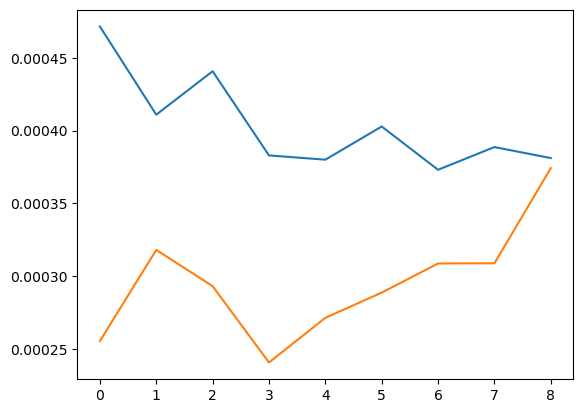

In [ ]:
plt.plot(train_error[1:])
plt.plot(val_error[1:])

In [33]:
best_model

GRU(
  (gru): GRU(1, 4, num_layers=4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [34]:
best_model.load_state_dict(torch.load("data/models/early_stopping_no_sentiment.pt"))

<All keys matched successfully>

In [35]:
y_pred_test = best_model(X_test_tensor)\
    .detach()\
    .numpy()

y_pred_train = best_model(X_train_tensor)\
    .detach()\
    .numpy()

In [36]:
X_train_tensor.shape

torch.Size([5590, 10, 1])

In [37]:
y_pred_test.reshape(-1).shape

(3470,)

In [38]:
y_pred_test = pd.Series(
    y_pred_test\
        .reshape(-1),
    name = "price",
    index = y_test.index      
)

y_pred_train = pd.Series(
    y_pred_train\
        .reshape(-1),
    name = "price",
    index = y_train.index      
)


In [39]:
company_train = y_pred_train\
    .index\
    .get_level_values("ticker") == "AAPL"


company_test = y_pred_test\
    .index\
    .get_level_values("ticker") == "AAPL"

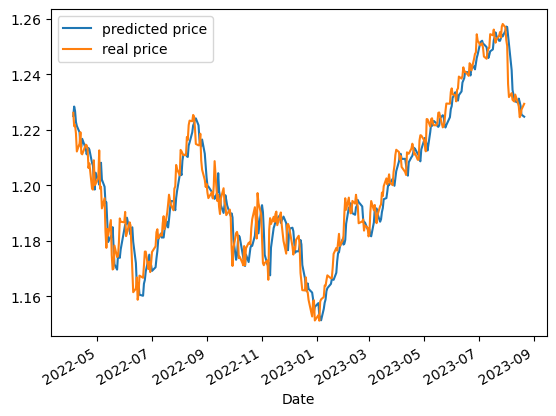

In [40]:
y_pred_test[company_test]\
    .reset_index(level=1)\
    ["price"]\
    .plot(
        label = "predicted price"
    )

y_test[company_test]\
    .reset_index(level=1)\
    ["price"]\
    .plot(
        label = "real price"
    )

plt.legend()

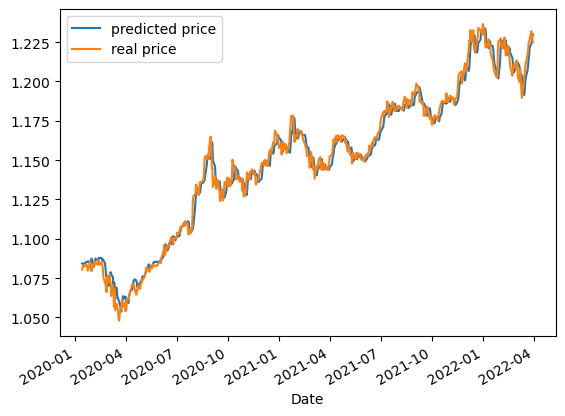

In [41]:
# plt.figure(figsize = (16,10))

y_pred_train[company_train]\
    .reset_index(level= "ticker")\
    ["price"]\
    .plot(
        label = "predicted price",
        # color = "blue"
    )

y_train[company_train]\
    .reset_index(level= "ticker")\
    ["price"]\
    .plot(
        label = "real price",
        # color = "blue"
    )




plt.legend()

## PnL

In [42]:
backtester = Backtester(
    universe,
    y_pred_train,
    y_pred_test,
    y_train,
    y_test
)

In [43]:
backtester.backtest()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 133.84it/s]


In [44]:
backtester.get_backtest_results()

[*********************100%***********************]  1 of 1 completed


,sharpes,information_ratios,p-values,annualized_vol
train,0.787610,0.147103,0.118834,0.265496
val,1.537395,1.993361,0.092971,0.279577
test,2.022291,2.170618,0.040109,0.211974
full_period,1.099352,0.806245,0.017682,0.260538


In [ ]:
# torch.save(best_model.state_dict(), "data/models/early_stopping_no_sentiment.pt")

## Generating backtest images

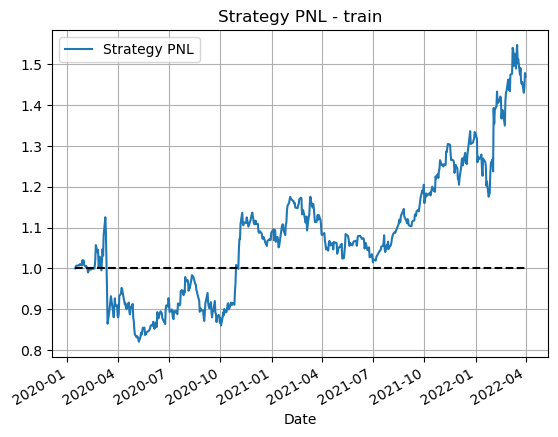

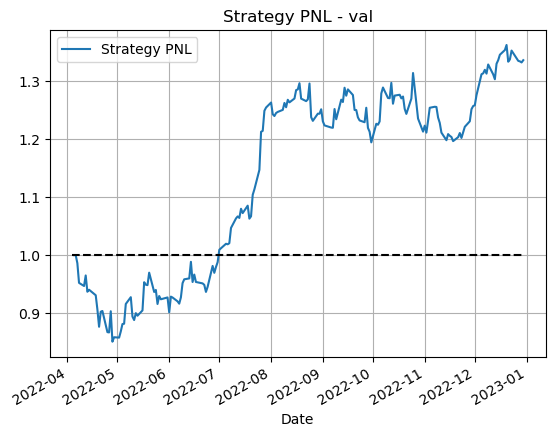

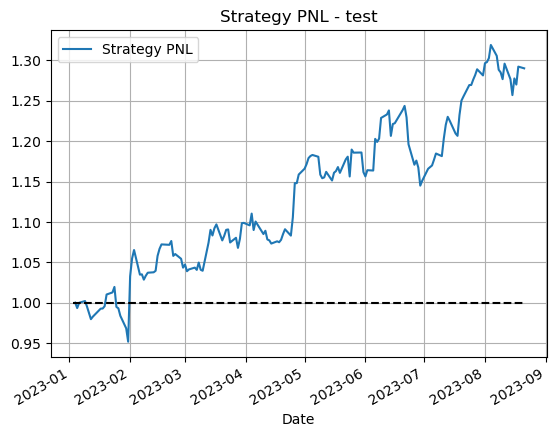

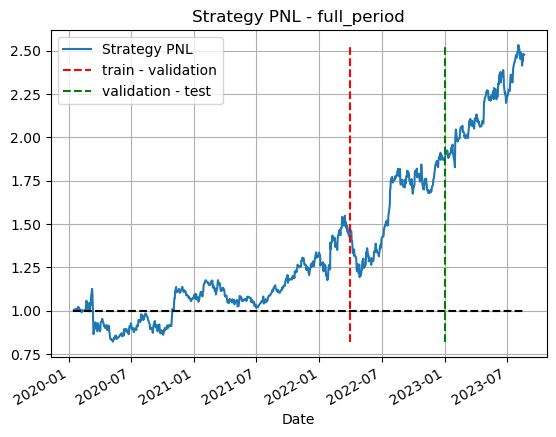

In [45]:
periods = ["train", "val", "test", "full_period"]

for period in periods:
    pnl_total = backtester.get_backtest_pnl()[period]
    plt.title(f"Strategy PNL - {period}")

    cumulative_pnl = pnl_total\
        .add(1)\
        .cumprod()
    
    cumulative_pnl.plot(
        label = "Strategy PNL"
    )

    plt.hlines(
        y = 1,
        xmin= pnl_total.index[0],
        xmax = pnl_total.index[-1],
        colors= "black",
        linestyles= "dashed"
    )

    if period == "full_period":

        plt.vlines(
            x = pd.to_datetime("2022-04"),
            ymin = cumulative_pnl.min(),
            ymax = cumulative_pnl.max(),
            colors= "red",
            linestyles= "dashed",
            label = "train - validation"
        )

        plt.vlines(
            x = pd.to_datetime('2023-01'),
            ymin = cumulative_pnl.min(),
            ymax = cumulative_pnl.max(),
            colors= "green",
            linestyles= "dashed",
            label = "validation - test"
        )

    plt.legend()
    plt.grid()
    # plt.savefig(f"img/strategy_{period}.png", bbox_inches = "tight")
    plt.show()



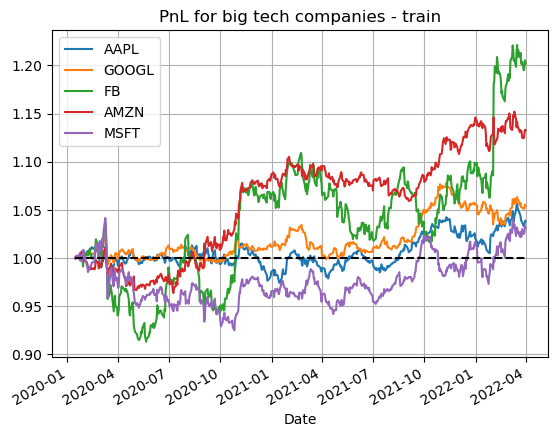

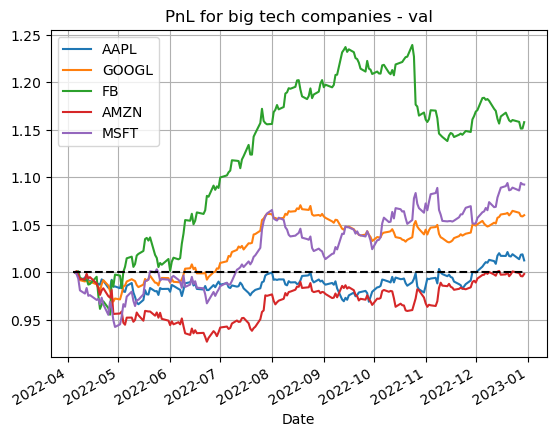

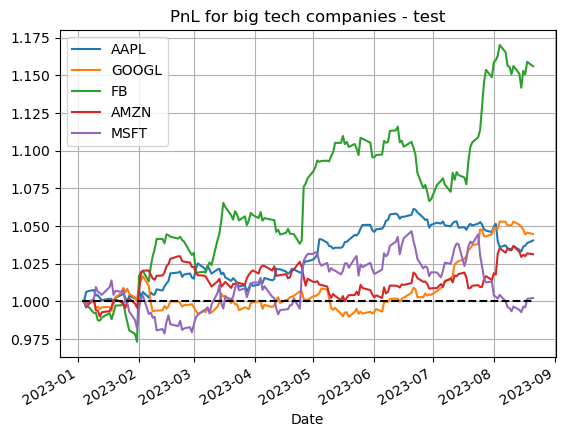

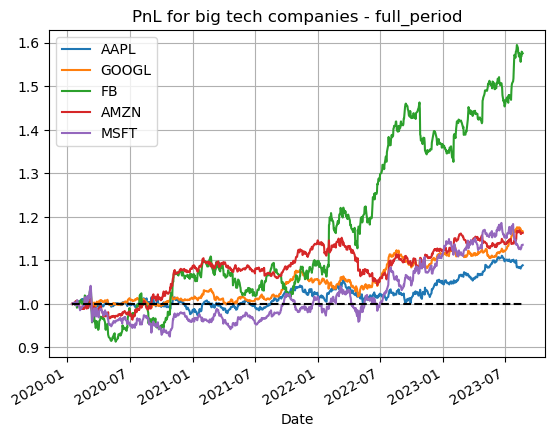

In [46]:
pnls_by_company = backtester.get_backtest_pnl_by_company()
periods = ["train", "val", "test", "full_period"]

for period in periods:
    for company in ["AAPL", "GOOGL", "FB", "AMZN", "MSFT"]:
        company_pnl = pnls_by_company[period][company]

        cumulative_company_pnl = company_pnl\
            .add(1)\
            .cumprod()
        
        cumulative_company_pnl.plot(
            label = company
        )

    plt.hlines(
        y = 1,
        xmin= cumulative_company_pnl.index[0],
        xmax = cumulative_company_pnl.index[-1],
        colors= "black",
        linestyles= "dashed"
    )

    plt.title(f"PnL for big tech companies - {period}")
    plt.legend()
    plt.grid()
    # plt.savefig(f"img/strategy_total_{period}.png", bbox_inches = "tight")
    plt.show()
